# FAST detector and BRIEF descriptor

This notebook presents implementation of FAST detector and BRIEF descriptor as separate python script.

Also there are some helper methods for blur addition, pixel restoration, etc.

In [1]:
import sys
import cv2
import os
from matplotlib import pyplot as plt

sys.path.insert(0, '../helpers/')

from fast_brief import *

In [2]:
%matplotlib inline

In [3]:
img_in_path = os.path.join(os.getcwd(), 'tracking')

## Feature detection using FAST

![Fast feature detector](fast_example.jpg)

*The highlighted squares are the pixels used in the corner detection. The pixel at p is the center of a candidate corner. The arc is indicated by the dashed line passes through 12 contiguous pixels which are brighter than p by more than the threshold.*

The general algorithm goes like this:
- Select a pixel **p** which is a point of interest in the image. The intensity of **p** is denoted as **Ip**.
- Select threshold value **t**. This value is used to detect the contiguous pixels, that are brighter that **p** by value **t**
- Concider a circle of 16 pixels around the interest pixel **p**. The circle is drawn with the **Midpoint circle algorithm** as it is **Bresenham circle**. 
- The pixel **p** is concidered a corner if there is a set of **n** contiguous pixels in the circle of 16 pixels (previous step) which are all brighter than the value **Ip + t** or darker than **Ip - t**
- We first check pixels 1,5,9,13 in the image above with the **Ip** value. 
- If at least three of the four-pixel values are not **above or below Ip + t**, then p is not an interest point (corner). In this case **reject the pixel p as a possible interest point.**
- Else if **at least three of the pixels are above or below Ip + t**, then check for all 16 pixels and check if 12 contiguous pixels fall in the criterion.


First, for n<12, the algorithm does not work very well in all cases because when n<12 the number of interest points detected are very high. Second, the order in which the 16 pixels are queried determines the speed of the algorithm.

## Bresenham circle

![Bresenham](bresenham.png)

*This algorithm draws all eight octants simultaneously, starting from each cardinal direction (0°, 90°, 180°, 270°) and extends both ways to reach the nearest multiple of 45° (45°, 135°, 225°, 315°). It can determine where to stop because when y = x, it has reached 45°. The reason for using these angles is shown in the above picture: As y increases, it does not skip nor repeat any y value until reaching 45°. So during the while loop, y increments by 1 each iteration, and x decrements by 1 on occasion, never exceeding 1 in one iteration. This changes at 45° because that is the point where the tangent is rise=run. Whereas rise>run before and rise<run after.*

*The second part of the problem, the determinant, is far trickier. This determines when to decrement x. It usually comes after drawing the pixels in each iteration, because it never goes below the radius on the first pixel. Because in a continuous function, the function for a sphere is the function for a circle with the radius dependent on z (or whatever the third variable is), it stands to reason that the algorithm for a discrete(voxel) sphere would also rely on this Midpoint circle algorithm. But when looking at a sphere, the integer radius of some adjacent circles is the same, but it is not expected to have the same exact circle adjacent to itself in the same hemisphere. Instead, a circle of the same radius needs a different determinant, to allow the curve to come in slightly closer to the center or extend out farther.*

## Median blur 

The Median Filter is a non-linear digital filtering technique, often used to remove noise from an image or signal. 

The main idea of the median filter is to run through the signal entry by entry, replacing each entry with the median of neighboring entries. The pattern of neighbors is called the "window", which slides, entry by entry, over the entire signal. For 1D signals, the most obvious window is just the first few preceding and following entries, whereas for 2D (or higher-dimensional) signals such as images, more complex window patterns are possible (such as "box" or "cross" patterns).

You could also apply **Gaussian blur** to the image by using *feature_detector_helper.py* function *gaussian_kernel*

## Non-Maximum supression

This technique is used to throw away irrelevant or repeating corners and thus faster up the algorithm overall. The usage of this technique was inspired by Tibliu.

The algorithm goes next:

- Check if corners *c_i* and *c_i-1* are adjacent, where *c_i* is current pixel and *c_i-1* is previous pixel. 
- If they are - discard one with the smallest value.
- Repeat for all pixels.

## Testing the solution

Let us load couple of images for testing. The most significant hyperparameter here is the **threshold** that should be adjusted for every image.

In [4]:
def get_test_image_path(image_name):
    return os.path.join(img_in_path, image_name + '.png')

def detect_corners_on_image(image_name, threshold):
    sample_image = cv2.imread(get_test_image_path(image_name), 0)
    corners = fast_detection(sample_image, threshold = threshold)
    print("Found %d corners on image %s" % (len(corners), image_name))

    plt.figure(figsize=(6,4))
    implot = plt.imshow(sample_image, cmap='gray')

    for corner in corners:
        plt.scatter(corner[0], corner[1], s=1, c = 'red')
    
    plt.title("Corners on %s" % image_name)
    plt.show()

Found 157 corners on image rotation_2_0


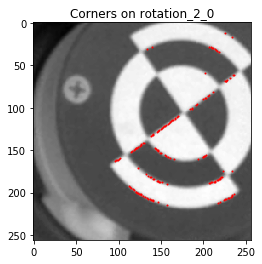

Found 130 corners on image rotation_2_1


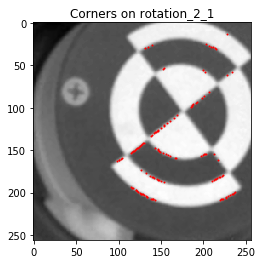

Found 131 corners on image rotation_2_2


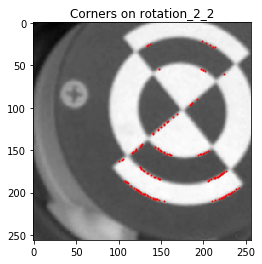

Found 115 corners on image rotation_2_3


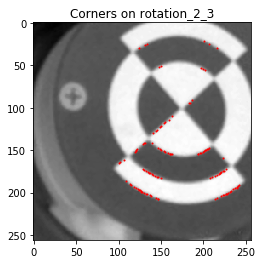

Found 106 corners on image rotation_2_4


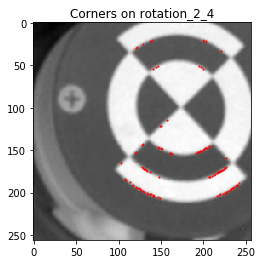

Found 105 corners on image rotation_2_5


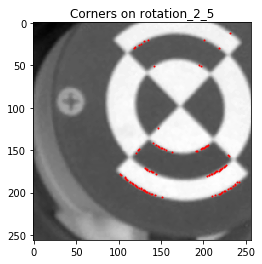

Found 92 corners on image rotation_2_6


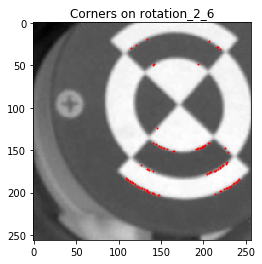

In [10]:
detect_corners_on_image('rotation_2_0', threshold = 50)
detect_corners_on_image('rotation_2_1', threshold = 50)
detect_corners_on_image('rotation_2_2', threshold = 50)
detect_corners_on_image('rotation_2_3', threshold = 50)
detect_corners_on_image('rotation_2_4', threshold = 50)
detect_corners_on_image('rotation_2_5', threshold = 50)
detect_corners_on_image('rotation_2_6', threshold = 50)

We can see that even without changing the **threshold** the amount of corners detected on the images remains pretty well even during rotation.

Let us check last (and most) rotated images. The first (rotation_2_0) would be added for visual comparison.

Found 157 corners on image rotation_2_0


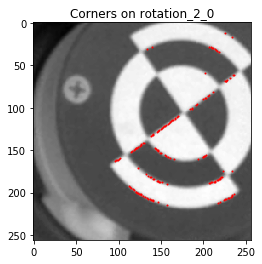

Found 109 corners on image rotation_2_7


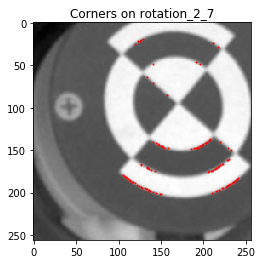

Found 111 corners on image rotation_2_8


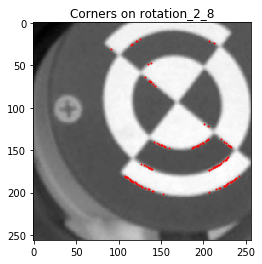

Found 117 corners on image rotation_2_9


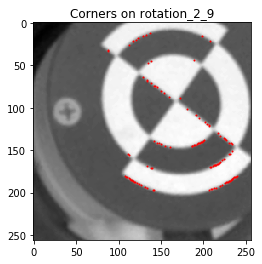

In [11]:
detect_corners_on_image('rotation_2_0', threshold = 50)
detect_corners_on_image('rotation_2_7', threshold = 50)
detect_corners_on_image('rotation_2_8', threshold = 50)
detect_corners_on_image('rotation_2_9', threshold = 50)

Still the amount of corners found remains almost the same (+- 40 corner points) **without changing the threshold parameter at all**. So, we could state that the implemented method works well both from empirical point of view and numerical.

## BRIEF feature descriptor

BRIEF is very fast both to build and to match.BRIEF easily outperforms other fast descriptors such as SURF and SIFT in terms of speed and terms of recognition rate in many cases.

After detecting keypoint we go on to compute a descriptor for every one of them. Feature descriptors encode interesting information into a series of numbers and act as a sort of numerical “fingerprint” that can be used to differentiate one feature from another.

![Brief patch](brief_keypoint_2.png)

The neighbourhood pixels, defined around the keypoint is known as patch, which is usually a square of size *n by m*. Image patches could be eﬀectively classiﬁed on the basis of a relatively small number of pair-wise intensity comparisons. Brief convert image patches into a binary feature vector so that together they can represent an object.

![Brief patch](binary_feature_vector.png)

## BRIEF sensitivity

Brief deals with the image at pixel level so it is very noise-sensitive. By pre-smoothing the patch, this sensitivity can be reduced, thus increasing the stability and repeatability of the descriptors.

The logic would be the same as with **FAST** corner detector - to apply median or Gaussian blur on the image with some relatively small kernel size in order to decrease the salt and pepper noise.

**The general algorithm flow could be described next:**

- Pre-compute keypoints by some other algorithm (for example - FAST)
- Smooth the image if it was not previously smoothed (usually it is)
- Take each keypoint
- Compute patch for this keypoint
- Create a binary feature vector for this patch (we create binary feature vector of test responses tau). Choosing a set of n(x,y)-location pairs uniquely deﬁnes a set of binary tests.

![Binary test](binary_test_2.png)

- Select **n-test(random pairs** for creating output binary vector using Sampling Geometries

![Sampling geometry](sampling_geometry.jpeg)

We consider the size of patch p is *(S x S)* and assuming keypoint is **located in the center of the patch.**

- **Uniform(G I):** Both x and y pixels in the random pair is drawn from a Unifrom distribution or spread of S/2 around keypoint. The pair(test) can lie close to the patch border.

- **Gaussian(G II):** Both x and y pixels in the random pair is drawn from a Gaussian distribution or spread of 0.04 * S² around keypoint.

- **Gaussian(G III):** The first pixel(x) in the random pair is drawn from a Gaussian distribution centered around the keypoint with a stranded deviation or spread of 0.04 * S². The second pixel(y) in the random pair is drawn from a Gaussian distribution centered around the first pixel(x) with a standard deviation or spread of 0.01 * S². This forces the test(pair) to be more local. Test(pair) locations outside the patch are clamped to the edge of the patch.

- **Coarse Polar Grid(G IV):** Both x and y pixels in the random pair is sampled from discrete locations of a coarse polar grid introducing a spatial quantization.

- **Coarse Polar Grid(G V):** The first pixel(x) in random pair is at (0, 0) and the second pixel(y) in the random pair is drawn from discrete locations of a coarse polar grid.

The plot of recognition rate for these images could be shown as

![Recognition rate](recognition_rate.png)

And the formula for calculating BRIEF descriptor function will look like

![Brief formula](brief_formula.png)

Most of the sources are from Michael Calonder, Vincent Lepetit, et al. *BRIEF: Binary Robust Independent Elementary Features*